In [45]:
import pandas as pd

# Read the data
df = pd.read_csv('./data/news/all_articles_combined_machine_annotation.csv')
df_cov = pd.read_csv('./data/crime_pop_freq.csv')
df_cov = df_cov.fillna(0)

In [46]:
# Define valid US state codes (50 states + DC)
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 
                'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME',
                'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH',
                'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI',
                'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

# Filter to only valid US states
df = df[df['location'].isin(states)]

df_frequency = df.groupby(['location', 'date']).size().reset_index(name='frequency')

print(f"Original data shape: {df.shape}")
print(f"Grouped data shape: {df_frequency.shape}")
print("\nFirst 10 rows:")
print(df_frequency.head(10))
print("\nSummary statistics:")
print(df_frequency['frequency'].describe())


Original data shape: (7237, 14)
Grouped data shape: (1365, 3)

First 10 rows:
  location     date  frequency
0       AK  2022/07          1
1       AK  2023/01          1
2       AK  2024/12          1
3       AK  2025/08          1
4       AL  2022/03          1
5       AL  2022/04          1
6       AL  2022/05         21
7       AL  2022/06          1
8       AL  2022/07          3
9       AL  2022/08          1

Summary statistics:
count    1365.000000
mean        5.301832
std        10.411041
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       181.000000
Name: frequency, dtype: float64


In [47]:
# Convert date to datetime to find full range
df_frequency['date_dt'] = pd.to_datetime(df_frequency['date'], format='%Y/%m')

# Get min and max dates
min_date = df_frequency['date_dt'].min()
max_date = df_frequency['date_dt'].max()

# Create complete date range (all months from min to max)
all_dates = pd.date_range(start=min_date, end=max_date, freq='MS')
all_dates_str = all_dates.strftime('%Y/%m').tolist()

# Create complete grid: all locations × all dates
complete_grid = pd.MultiIndex.from_product(
    [states, all_dates_str],
    names=['location', 'date']
).to_frame(index=False)

# Merge with actual frequency data
df_frequency_filled = complete_grid.merge(
    df_frequency[['location', 'date', 'frequency']],
    on=['location', 'date'],
    how='left'
)

# Fill NaN with 0
df_frequency_filled['frequency'] = df_frequency_filled['frequency'].fillna(0).astype(int)


In [48]:
# Create g column (first treatment time group)
# DC treated in 2025/08, IL treated in 2025/09, others never treated (0)
df_frequency_filled['g'] = 0
df_frequency_filled.loc[df_frequency_filled['location'] == 'DC', 'g'] = '2025/08'
df_frequency_filled.loc[df_frequency_filled['location'] == 'IL', 'g'] = '2025/09'

# Create d column (binary treatment indicator)
# 1 if location is treated AND date >= treatment date, else 0
df_frequency_filled['d'] = 0

# DC treated from 2025/08 onwards
df_frequency_filled.loc[
    (df_frequency_filled['location'] == 'DC') & 
    (df_frequency_filled['date'] >= '2025/08'), 
    'd'
] = 1

# IL treated from 2025/09 onwards
df_frequency_filled.loc[
    (df_frequency_filled['location'] == 'IL') & 
    (df_frequency_filled['date'] >= '2025/09'), 
    'd'
] = 1


/var/folders/8g/6g1j06xd7ms8hzz2_27br4vh0000gn/T/ipykernel_54595/3150635433.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025/08' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_frequency_filled.loc[df_frequency_filled['location'] == 'DC', 'g'] = '2025/08'


/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/didcont/estimation/process_attgt.py:65: UserWarning: Not returning pre-test Wald statistic due to singular covariance matrix
  warnings.warn("Not returning pre-test Wald statistic due to singular covariance matrix", UserWarning)
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/didcont/estimation/process_attgt.py:174: UserWarning: Simultaneous confidence band is smaller than pointwise one. Reporting pointwise confidence intervals instead.
  warnings.warn(
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/didcont/estimation/process_attgt.py:174: UserWarning: Simultaneous confidence band is smaller than pointwise one. Reporting pointwise confidence intervals instead.
  warnings.warn(
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/didcont/estimation/process_attgt.py:1

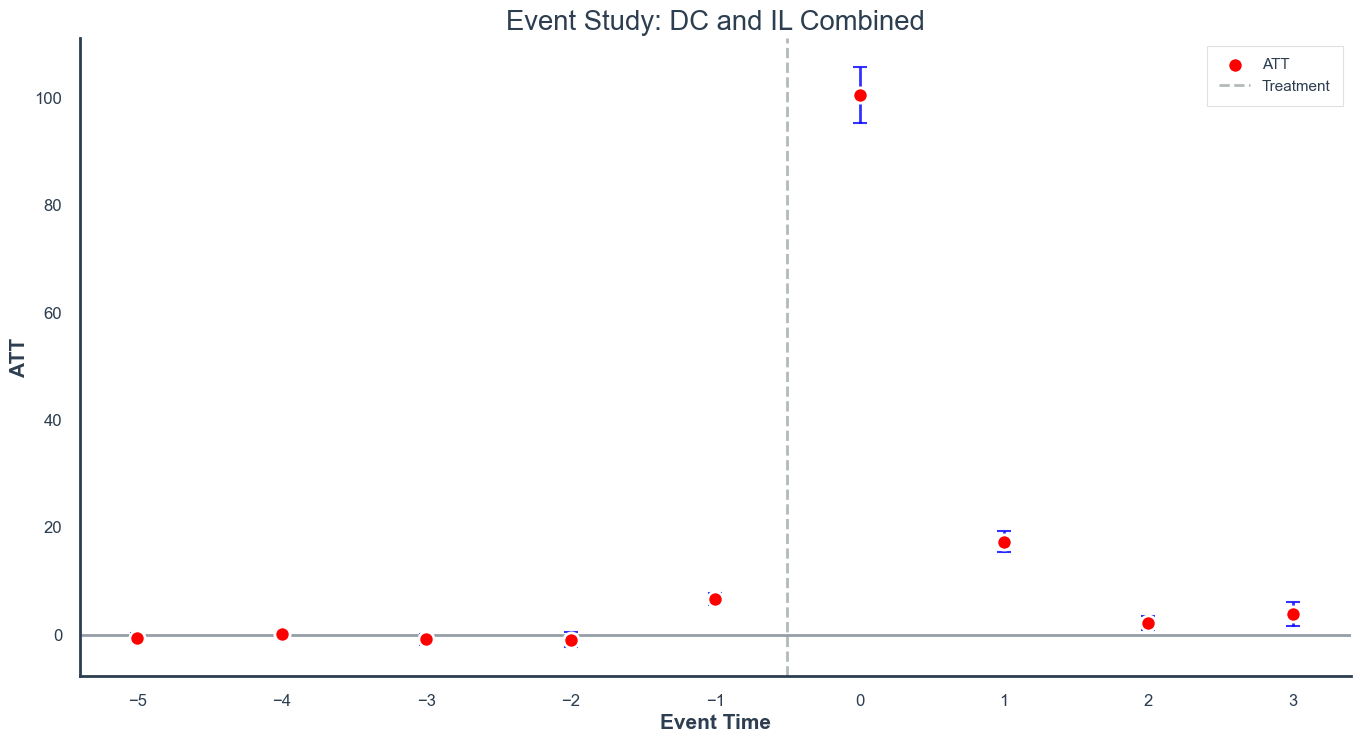

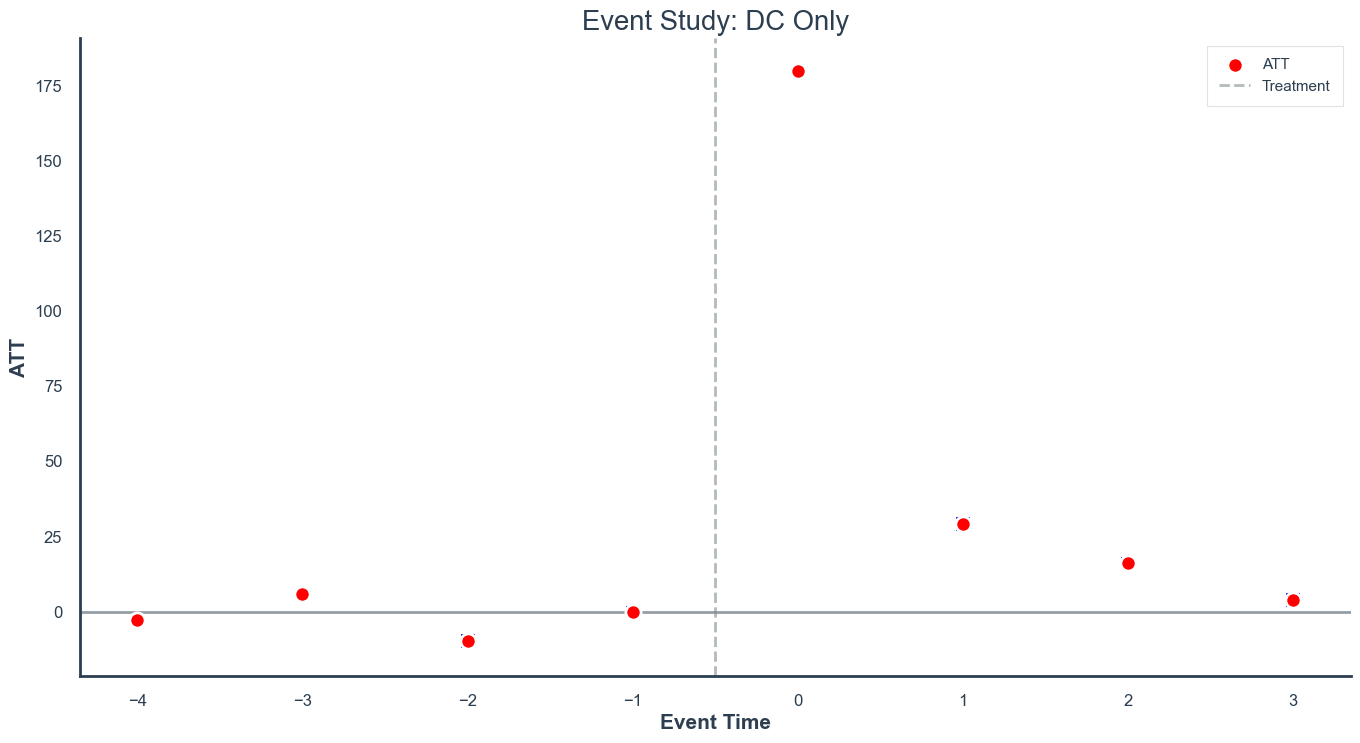

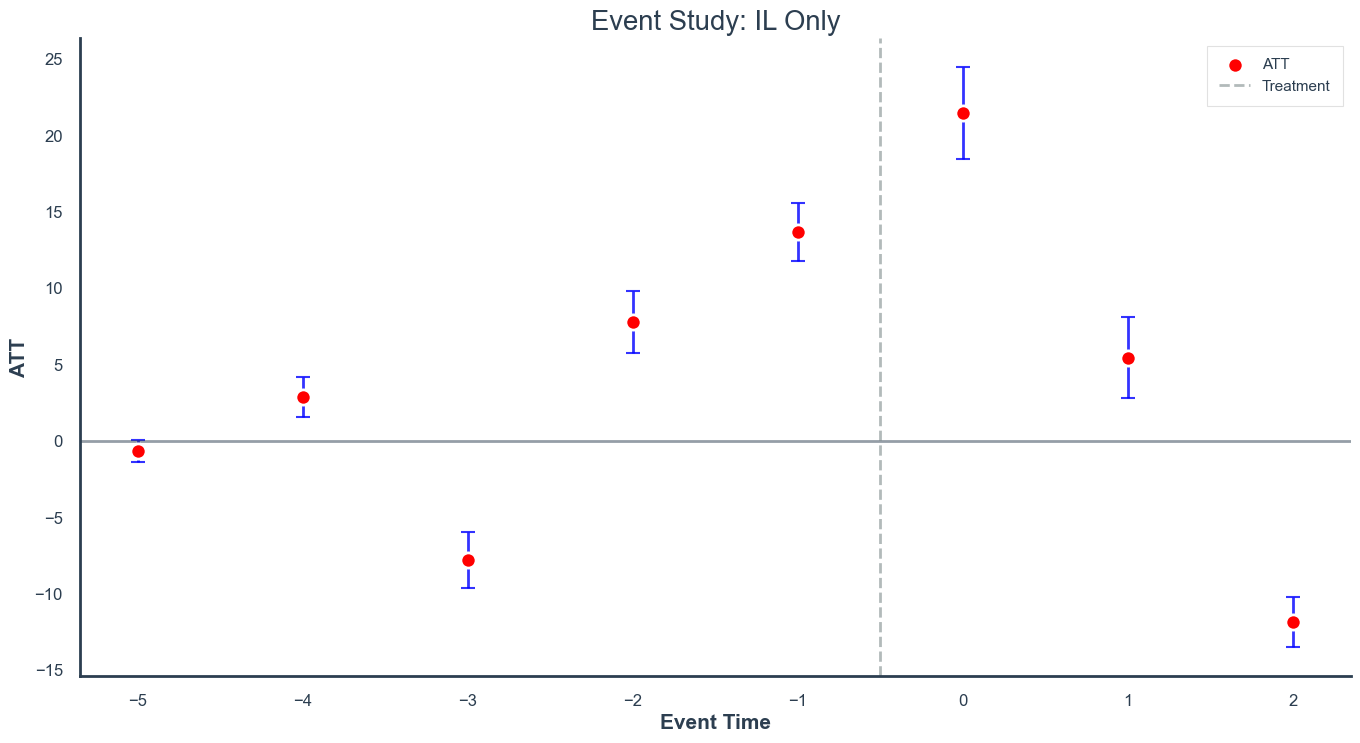

In [49]:
# Imports
from moderndid.didcont import cont_did
from moderndid.didcont.plots import plot_cont_did
import matplotlib.pyplot as plt

# Data prep
df_panel = df_frequency_filled.copy()
df_panel['date_dt'] = pd.to_datetime(df_panel['date'], format='%Y/%m')
# Create time_period in YYYYMM format (e.g., 202201 for 2022/01)
df_panel['time_period'] = df_panel['date_dt'].dt.year * 100 + df_panel['date_dt'].dt.month
df_panel['id'] = pd.Categorical(df_panel['location']).codes

# Treatment times in YYYYMM format
dc_treat_time = 202508  # 2025/08
il_treat_time = 202509  # 2025/09

min_treat_time = min(dc_treat_time, il_treat_time)
# Keep data from 5 months before earliest treatment
df_panel = df_panel[df_panel['time_period'] >= (min_treat_time - 5)]

df_panel['G'] = 0
df_panel.loc[df_panel['location'] == 'DC', 'G'] = dc_treat_time
df_panel.loc[df_panel['location'] == 'IL', 'G'] = il_treat_time
df_panel['D'] = 0
df_panel.loc[df_panel['location'] == 'DC', 'D'] = 1
df_panel.loc[df_panel['location'] == 'IL', 'D'] = 1
df_panel['Y'] = df_panel['frequency']

# Model 1: Both DC and IL
cd_both = cont_did(
    yname="Y",
    tname="time_period",
    idname="id",
    dname="D",
    data=df_panel,
    gname="G",
    target_parameter="level",
    aggregation="eventstudy",
    treatment_type="continuous",
    control_group="notyettreated",
    biters=100,
    cband=True,
    num_knots=1,
    degree=3,
)

# Model 2: DC only
df_dc = df_panel[df_panel['location'].isin(['DC'] + [s for s in states if s not in ['DC', 'IL']])].copy()
df_dc = df_dc[df_dc['G'].isin([0, dc_treat_time])]

cd_dc = cont_did(
    yname="Y",
    tname="time_period",
    idname="id",
    dname="D",
    data=df_dc,
    gname="G",
    target_parameter="level",
    aggregation="eventstudy",
    treatment_type="continuous",
    control_group="notyettreated",
    biters=100,
    cband=True,
    num_knots=1,
    degree=3,
)

# Model 3: IL only
df_il = df_panel[df_panel['location'].isin(['IL'] + [s for s in states if s not in ['DC', 'IL']])].copy()
df_il = df_il[df_il['G'].isin([0, il_treat_time])]

cd_il = cont_did(
    yname="Y",
    tname="time_period",
    idname="id",
    dname="D",
    data=df_il,
    gname="G",
    target_parameter="level",
    aggregation="eventstudy",
    treatment_type="continuous",
    control_group="notyettreated",
    biters=100,
    cband=True,
    num_knots=1,
    degree=3,
)

# Plot 1: Both
fig1 = plot_cont_did(cd_both, type='att', show_confidence_bands=True)
plt.title('Event Study: DC and IL Combined')
plt.show()

# Plot 2: DC
fig2 = plot_cont_did(cd_dc, type='att', show_confidence_bands=True)
plt.title('Event Study: DC Only')
plt.show()

# Plot 3: IL
fig3 = plot_cont_did(cd_il, type='att', show_confidence_bands=True)
plt.title('Event Study: IL Only')
plt.show()

          lb          ub method    delta  Mbar
0  92.860927  107.988461   C-LF  DeltaRM   0.5
1  88.939563  111.909825   C-LF  DeltaRM   1.0
2  84.867382  115.982006   C-LF  DeltaRM   1.5
3  80.831746  120.017642   C-LF  DeltaRM   2.0


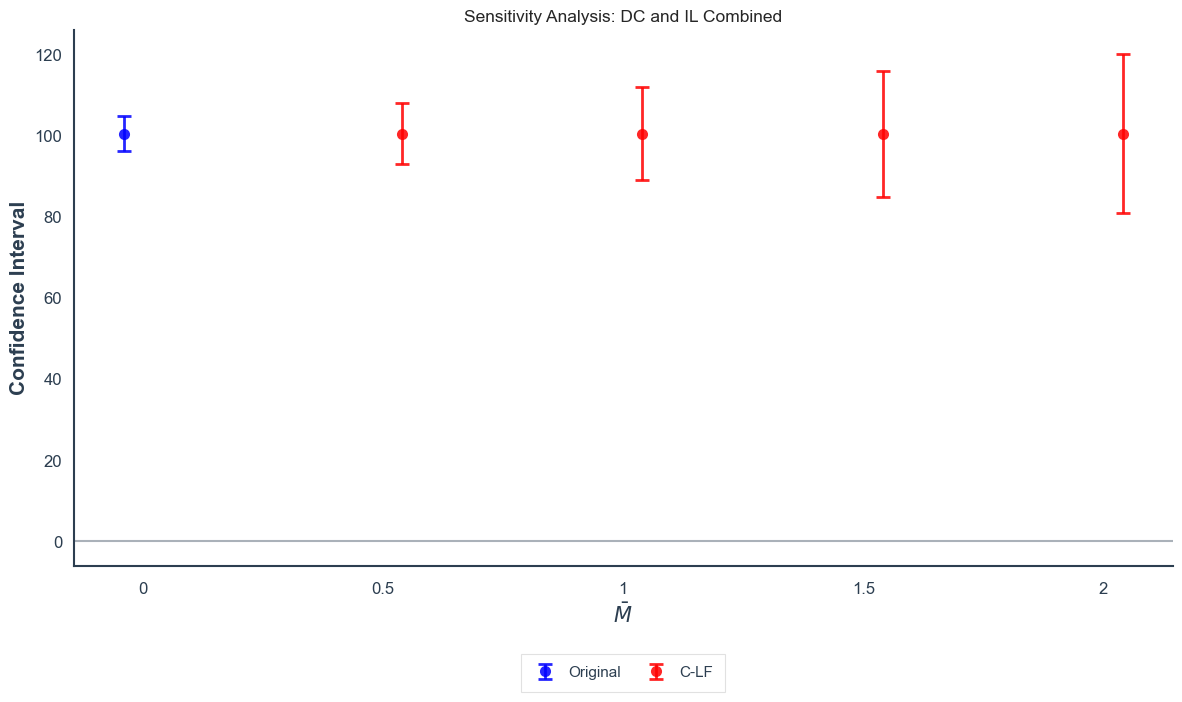

In [50]:
import numpy as np
from moderndid import create_sensitivity_results_rm, construct_original_cs, plot_sensitivity_rm

# Extract event study results from cd_both.event_study (PTEAggteResult object)
event_times = cd_both.event_study.event_times
att_by_event = cd_both.event_study.att_by_event
se_by_event = cd_both.event_study.se_by_event

# Separate pre and post treatment periods
pre_mask = event_times < 0
post_mask = event_times >= 0

# Extract coefficients in order: pre-treatment first, then post-treatment
betahat = np.concatenate([att_by_event[pre_mask], att_by_event[post_mask]])
se_all = np.concatenate([se_by_event[pre_mask], se_by_event[post_mask]])

# Construct variance-covariance matrix from standard errors
sigma = np.diag(se_all ** 2)

num_pre_periods = int(np.sum(pre_mask))
num_post_periods = int(np.sum(post_mask))

# Construct original confidence intervals
original_ci = construct_original_cs(
    betahat=betahat,
    sigma=sigma,
    num_pre_periods=num_pre_periods,
    num_post_periods=num_post_periods,
    alpha=0.05
)

# Sensitivity analysis using relative magnitudes
delta_rm_results = create_sensitivity_results_rm(
    betahat=betahat,
    sigma=sigma,
    num_pre_periods=num_pre_periods,
    num_post_periods=num_post_periods,
    m_bar_vec=[0.5, 1.0, 1.5, 2.0],
    method="C-LF"
)

print(delta_rm_results)

plot_sensitivity_rm(delta_rm_results, original_ci)
plt.title('Sensitivity Analysis: DC and IL Combined')
plt.show()

In [51]:
from moderndid import drdid
from IPython.display import display

# Prepare data for DC: pre=2025/07, post=2025/08
df_dc_drdid = df_cov[df_cov['date'].isin(['2025/07', '2025/08'])].copy()
df_dc_drdid['time'] = (df_dc_drdid['date'] == '2025/08').astype(int)
df_dc_drdid['treated'] = (df_dc_drdid['location'] == 'DC').astype(int)
df_dc_drdid['id'] = pd.Categorical(df_dc_drdid['location']).codes

# Prepare data for IL: pre=2025/08, post=2025/09
df_il_drdid = df_cov[df_cov['date'].isin(['2025/08', '2025/09'])].copy()
df_il_drdid['time'] = (df_il_drdid['date'] == '2025/09').astype(int)
df_il_drdid['treated'] = (df_il_drdid['location'] == 'IL').astype(int)
df_il_drdid['id'] = pd.Categorical(df_il_drdid['location']).codes

# Model 1: DC only, no covariates
drdid_dc_nocov = drdid(
    data=df_dc_drdid,
    y_col='frequency',
    time_col='time',
    treat_col='treated',
    id_col='id',
    panel=True,
    est_method='imp'
)

display(drdid_dc_nocov)

# Model 2: IL only, no covariates
drdid_il_nocov = drdid(
    data=df_il_drdid,
    y_col='frequency',
    time_col='time',
    treat_col='treated',
    id_col='id',
    panel=True,
    est_method='imp'
)

display(drdid_il_nocov)

# Model 3: DC only, with covariates
drdid_dc_cov = drdid(
    data=df_dc_drdid,
    y_col='frequency',
    time_col='time',
    treat_col='treated',
    id_col='id',
    panel=True,
    covariates_formula='~ crime_rate',
    est_method='imp'
)

display(drdid_dc_cov)

# Model 4: IL only, with covariates
drdid_il_cov = drdid(
    data=df_il_drdid,
    y_col='frequency',
    time_col='time',
    treat_col='treated',
    id_col='id',
    panel=True,
    covariates_formula='~ crime_rate',
    est_method='imp'
)

display(drdid_il_cov)

 Doubly Robust DiD Estimator (Improved Method)
 Computed from 102 observations and 17 covariates.

      Estimate  Std. Error   t-value  Pr(>|t|)  [95% Conf. Interval]
--------------------------------------------------------------------
ATT   179.3800      0.6864  261.3436    <0.001  [178.0347, 180.7253]

--------------------------------------------------------------------
 Method Details:
   Data structure: Panel data
   Outcome regression: Weighted least squares
   Propensity score: Inverse probability tilting

 Inference:
   Standard errors: Analytical
   Propensity score trimming: 0.995
 Reference: Sant'Anna and Zhao (2020), Journal of Econometrics

 Doubly Robust DiD Estimator (Improved Method)
 Computed from 102 observations and 17 covariates.

      Estimate  Std. Error  t-value  Pr(>|t|)  [95% Conf. Interval]
-------------------------------------------------------------------
ATT    24.4800      3.1487   7.7745    <0.001    [18.3085, 30.6515]

-------------------------------------------------------------------
 Method Details:
   Data structure: Panel data
   Outcome regression: Weighted least squares
   Propensity score: Inverse probability tilting

 Inference:
   Standard errors: Analytical
   Propensity score trimming: 0.995
 Reference: Sant'Anna and Zhao (2020), Journal of Econometrics

 Doubly Robust DiD Estimator (Improved Method)
 Computed from 102 observations and 17 covariates.

      Estimate  Std. Error   t-value  Pr(>|t|)  [95% Conf. Interval]
--------------------------------------------------------------------
ATT   178.3287      0.4073  437.8763    <0.001  [177.5304, 179.1269]

--------------------------------------------------------------------
 Method Details:
   Data structure: Panel data
   Outcome regression: Weighted least squares
   Propensity score: Inverse probability tilting

 Inference:
   Standard errors: Analytical
   Propensity score trimming: 0.995
 Reference: Sant'Anna and Zhao (2020), Journal of Econometrics

 Doubly Robust DiD Estimator (Improved Method)
 Computed from 102 observations and 17 covariates.

      Estimate  Std. Error  t-value  Pr(>|t|)  [95% Conf. Interval]
-------------------------------------------------------------------
ATT    23.9065      2.4702   9.6778    <0.001    [19.0649, 28.7482]

-------------------------------------------------------------------
 Method Details:
   Data structure: Panel data
   Outcome regression: Weighted least squares
   Propensity score: Inverse probability tilting

 Inference:
   Standard errors: Analytical
   Propensity score trimming: 0.995
 Reference: Sant'Anna and Zhao (2020), Journal of Econometrics

/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/core/preprocess/builders.py:125: UserWarning: 49 units were already treated in the first period and will be dropped
  warnings.warn(warning)
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/core/preprocess/builders.py:186: UserWarning: Be aware that there are some small groups in your dataset.
Check groups: 202508.0, 202509.0
  warnings.warn(warning_msg)
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/did/att_gt.py:278: UserWarning: Not returning pre-test Wald statistic due to singular covariance matrix
  warnings.warn(



Reference: Callaway and Sant'Anna (2021)

Group-Time Average Treatment Effects:
  Group   Time   ATT(g,t)   Std. Error  [95% Simult. Conf. Band]
 202508 202502    -0.0204       0.3074  [ -0.8539,   0.8131]  
 202508 202503     5.2245       0.3121  [  4.3784,   6.0706] *
 202508 202504    -2.6735       0.3493  [ -3.6207,  -1.7263] *
 202508 202505     5.8571       0.5570  [  4.3470,   7.3673] *
 202508 202506    -9.8163       0.9481  [-12.3869,  -7.2457] *
 202508 202507    -0.2245       0.7865  [ -2.3571,   1.9081]  
 202508 202508   179.6531       0.6314  [177.9412, 181.3649] *
 202508 202509    29.1224       1.0621  [ 26.2425,  32.0024] *
 202508 202510    16.1020       0.7781  [ 13.9924,  18.2117] *
 202508 202511     3.7959       0.9225  [  1.2946,   6.2973] *
 202509 202502     2.9796       0.3074  [  2.1461,   3.8131] *
 202509 202503     1.2245       0.3121  [  0.3784,   2.0706] *
 202509 202504    -0.6735       0.3493  [ -1.6207,   0.2737]  
 202509 202505     2.8571       0.5

 Aggregate Treatment Effects (Event Study)

 Call:
   aggte(MP, type='dynamic')

 Overall summary of ATT's based on event-study/dynamic aggregation:

   ATT          Std. Error     [95% Conf. Interval]
      30.9413       1.2854     [28.4221, 33.4606] *


 Dynamic Effects:

    Event time   Estimate   Std. Error   [95% Simult. Conf. Band]
            -7     2.9796       0.3376   [-23.2233, 29.1825]  
            -6     0.6020       0.3536   [-26.8467, 28.0508]  
            -5     2.2755       0.2843   [-19.7880, 24.3390]  
            -4     0.0918       0.5651   [-43.7672, 43.9509]  
            -3    -0.9796       0.9099   [-71.6042, 69.6450]  
            -2    -1.0204       0.7869   [-62.0936, 60.0527]  
            -1     6.7143       0.9907   [-70.1797, 83.6083]  
             0   100.5612       1.0171   [21.6176, 179.5049] *
             1    17.2857       1.4764   [-97.3051, 131.8766]  
             2     2.1224       1.2094   [-91.7445, 95.9894]  
             3     3.7959   

/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/did/plots/core.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


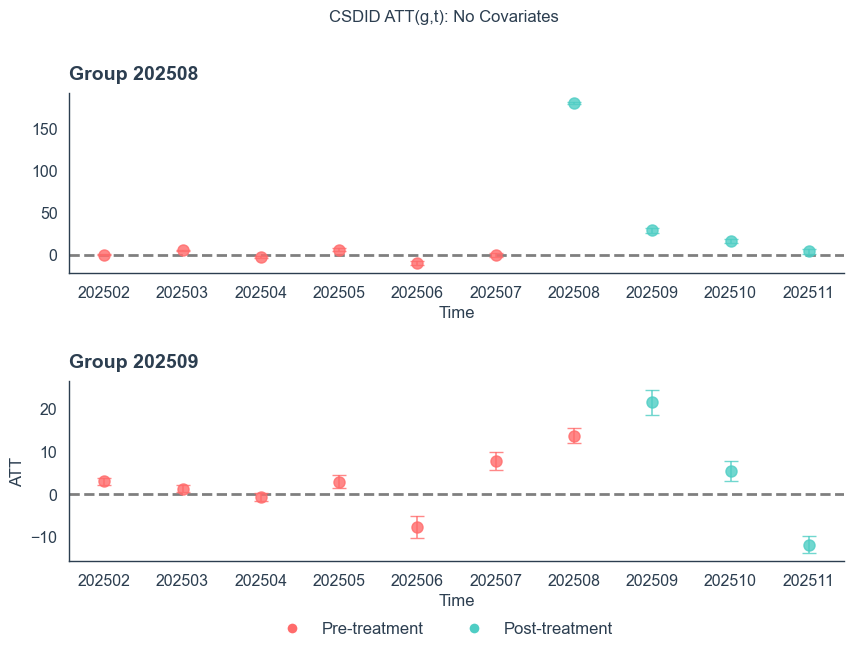

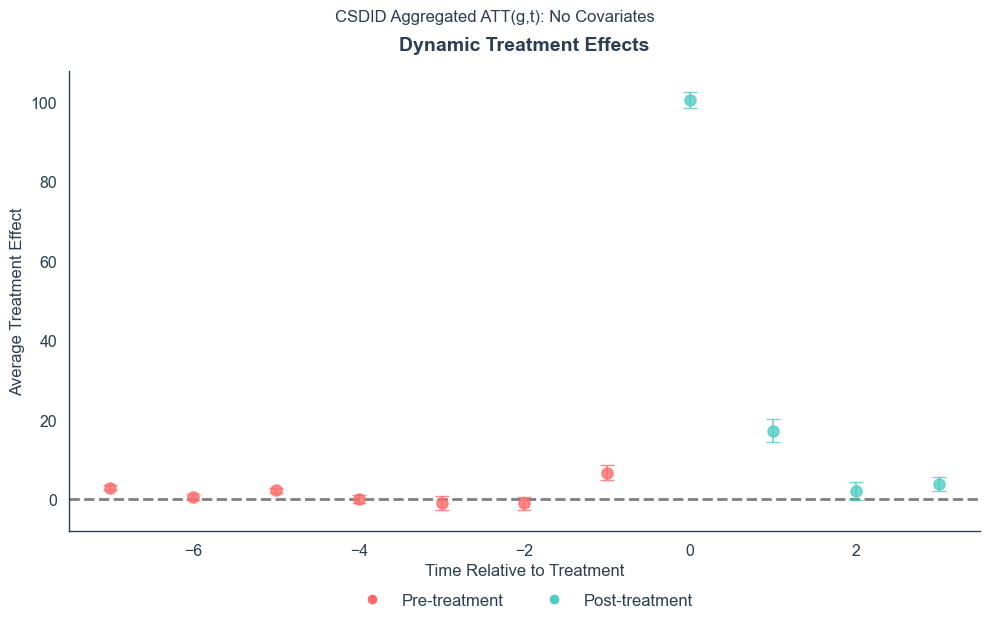

/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/core/preprocess/builders.py:125: UserWarning: 49 units were already treated in the first period and will be dropped
  warnings.warn(warning)
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/core/preprocess/builders.py:186: UserWarning: Be aware that there are some small groups in your dataset.
Check groups: 202508.0, 202509.0
  warnings.warn(warning_msg)



Reference: Callaway and Sant'Anna (2021)

Group-Time Average Treatment Effects:
  Group   Time   ATT(g,t)   Std. Error  [95% Simult. Conf. Band]
 202508 202502     0.4326       0.3055  [ -0.6014,   1.4667]  
 202508 202503     4.7006       0.3678  [  3.4556,   5.9456] *
 202508 202504    -1.9376       0.4518  [ -3.4669,  -0.4083] *
 202508 202505     6.0069       0.5403  [  4.1781,   7.8357] *
 202508 202506    -8.6044       0.2753  [ -9.5364,  -7.6725] *
 202508 202507     0.6166       0.6706  [ -1.6536,   2.8867]  
 202508 202508   177.5865       0.0897  [177.2829, 177.8900] *
 202508 202509    27.9329       0.6706  [ 25.6631,  30.2028] *
 202508 202510    14.9528       0.5261  [ 13.1719,  16.7337] *
 202508 202511     1.6754       0.1074  [  1.3118,   2.0390] *
 202509 202502     2.4606       0.3053  [  1.4271,   3.4940] *
 202509 202503     1.2912       0.2082  [  0.5864,   1.9960] *
 202509 202504    -0.8701       0.3747  [ -2.1385,   0.3983]  
 202509 202505     3.3620       0.5

 Aggregate Treatment Effects (Event Study)

 Call:
   aggte(MP, type='dynamic')

 Overall summary of ATT's based on event-study/dynamic aggregation:

   ATT          Std. Error     [95% Conf. Interval]
      29.8431       0.9003     [28.0785, 31.6078] *


 Dynamic Effects:

    Event time   Estimate   Std. Error   [95% Simult. Conf. Band]
            -7     2.4606       0.2799   [-21.3673, 26.2884]  
            -6     0.8619       0.3103   [-25.5564, 27.2803]  
            -5     1.9153       0.4921   [-39.9866, 43.8171]  
            -4     0.7122       0.8136   [-68.5580, 69.9824]  
            -3    -0.4822       0.7679   [-65.8611, 64.8966]  
            -2    -0.4007       0.6408   [-54.9605, 54.1590]  
            -1     7.0671       1.0346   [-81.0188, 95.1530]  
             0    99.5297       0.9168   [21.4689, 177.5904] *
             1    16.6895       1.6220   [-121.4120, 154.7910]  
             2     1.4780       1.3517   [-113.6109, 116.5669]  
             3     1.6754

/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/did/plots/core.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


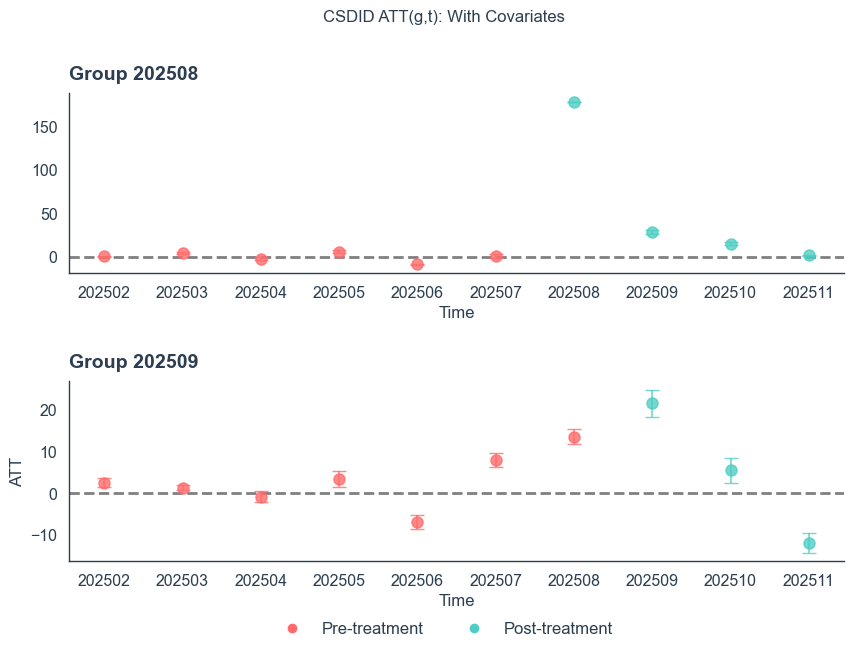

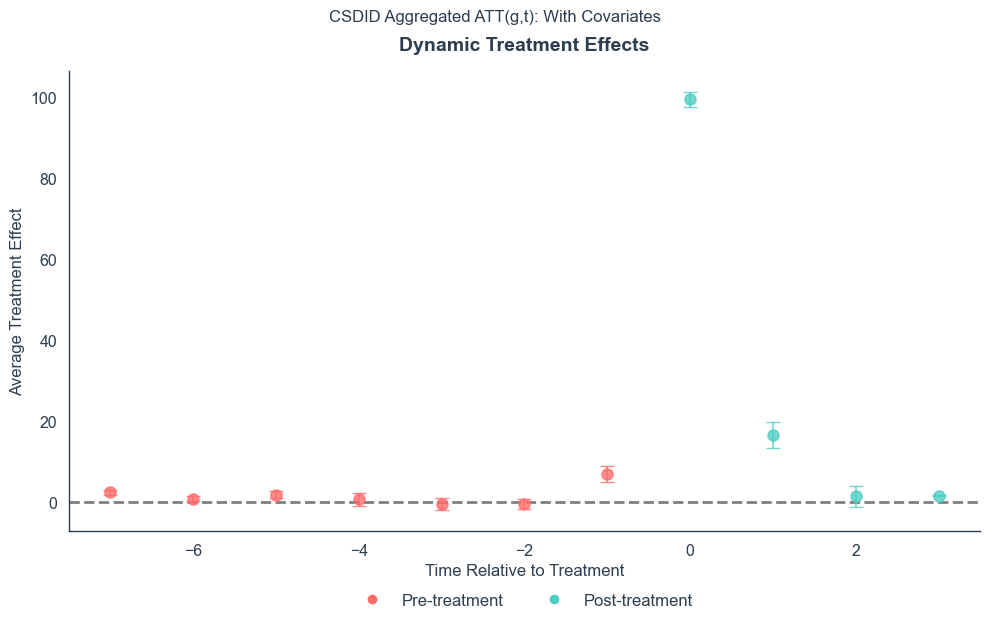

In [102]:
import moderndid as did

# Prepare data for CSDID
df_csdid = df_cov.copy()
df_csdid = df_csdid[df_csdid['date'] >= '2025/01']

# Convert date to datetime and create time_period in YYYYMM format (e.g., 202201 for 2022/01)
df_csdid['date_dt'] = pd.to_datetime(df_csdid['date'], format='%Y/%m')
df_csdid['time_period'] = df_csdid['date_dt'].dt.year * 100 + df_csdid['date_dt'].dt.month

# Create numeric ID
df_csdid['id'] = pd.Categorical(df_csdid['location']).codes

# Create gname column (first treatment period) in YYYYMM format
dc_treat_time = 202508  # 2025/08
il_treat_time = 202509  # 2025/09

df_csdid['first_treat'] = 0
df_csdid.loc[df_csdid['location'] == 'DC', 'first_treat'] = dc_treat_time
df_csdid.loc[df_csdid['location'] == 'IL', 'first_treat'] = il_treat_time

# Model 1: CSDID without covariates
csdid_nocov_attgt = did.att_gt(
    data=df_csdid,
    yname='frequency',
    tname='time_period',
    gname='first_treat',
    idname='id',
    est_method='dr',
    control_group='nevertreated',
    anticipation=0,
    allow_unbalanced_panel=True
)

csdid_nocov_aggte = did.aggte(csdid_nocov_attgt, type='dynamic', min_e=-12, max_e=10)

display(csdid_nocov_attgt)
display(csdid_nocov_aggte)

csdid_plot1 = did.plot_did(csdid_nocov_attgt)
csdid_plot1.suptitle('CSDID ATT(g,t): No Covariates', y=1.02)
csdid_plot1.savefig('./plot/csdid_attgt_nocov.png', bbox_inches='tight')
display(csdid_plot1)


csdid_plot2 = did.plot_did(csdid_nocov_aggte)
csdid_plot2.suptitle('CSDID Aggregated ATT(g,t): No Covariates', y=1.02)
csdid_plot2.savefig('./plot/csdid_aggte_nocov.png', bbox_inches='tight')
display(csdid_plot2)



# Model 2: CSDID with covariates
csdid_cov_attgt = did.att_gt(
    data=df_csdid,
    yname='frequency',
    tname='time_period',
    gname='first_treat',
    idname='id',
    xformla='~ crime_rate',
    est_method='dr',
    control_group='nevertreated',
    anticipation=0,
    allow_unbalanced_panel=True
)

csdid_cov_aggte = did.aggte(csdid_cov_attgt, type='dynamic', min_e=-12, max_e=10)

display(csdid_cov_attgt)
display(csdid_cov_aggte)

csdid_plot3 = did.plot_did(csdid_cov_attgt)
csdid_plot3.suptitle('CSDID ATT(g,t): With Covariates', y=1.02)
csdid_plot3.savefig('./plot/csdid_attgt_cov.png', bbox_inches='tight')
display(csdid_plot3)

csdid_plot4 = did.plot_did(csdid_cov_aggte)
csdid_plot4.suptitle('CSDID Aggregated ATT(g,t): With Covariates', y=1.02)
csdid_plot4.savefig('./plot/csdid_aggte_cov.png', bbox_inches='tight')
display(csdid_plot4)



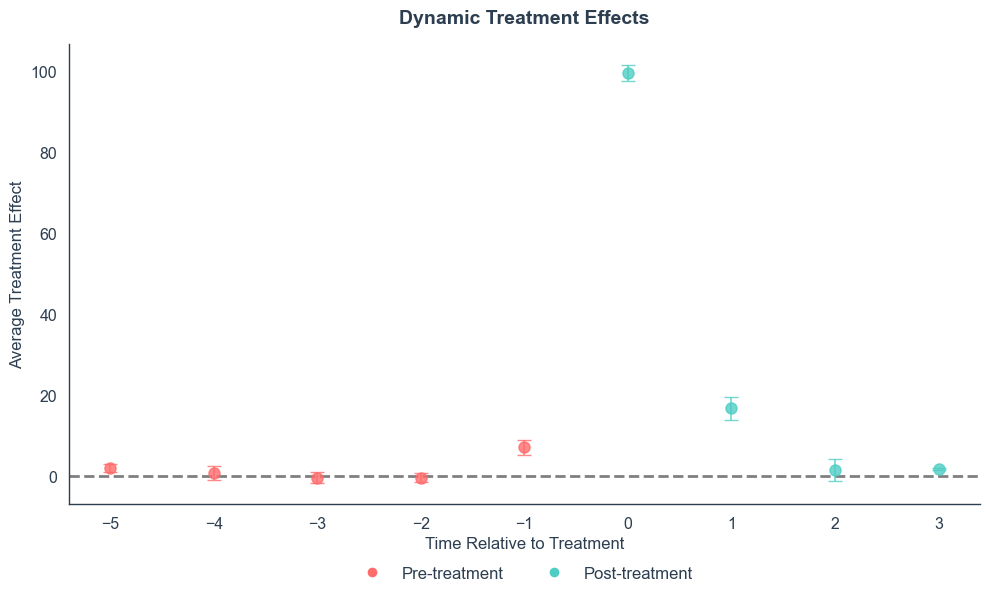

In [88]:
did.plot_did(csdid_cov_aggte)